*Reference: https://medium.com/swlh/5-tips-for-working-with-time-series-in-python-d889109e676d*

# Modeling Techniques to minimize effect of White Noise

* Importing Libraries

In [1]:
import yfinance as yf
import datetime  # For datetime objects
import backtrader as bt
import pandas as pd
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

* Dowloading data

In [2]:
#data_yf = bt.feeds.PandasData(dataname=yf.download('SPY', '2018-01-01', '2022-10-03'))

In [3]:
SPY = yf.download('SPY', '2000-01-01', '2022-10-03')

[*********************100%***********************]  1 of 1 completed


* Dataframe to series

In [4]:
SPY_series = SPY['Close'].squeeze()

* First we use Fast fourier transform denoiser to attempt to reduce white noise

*Reference: https://gist.github.com/Xylambda/b8f38dce74dd3d54ff906eebfe560ac0#file-denoiser-py*

In [5]:
def fft_denoiser(x, n_components, to_real=True):
    """Fast fourier transform denoiser.
    
    Denoises data using the fast fourier transform.
    
    Parameters
    ----------
    x : numpy.array
        The data to denoise.
    n_components : int
        The value above which the coefficients will be kept.
    to_real : bool, optional, default: True
        Whether to remove the complex part (True) or not (False)
        
    Returns
    -------
    clean_data : numpy.array
        The denoised data.
        
    References
    ----------
    .. [1] Steve Brunton - Denoising Data with FFT[Python]
       https://www.youtube.com/watch?v=s2K1JfNR7Sc&ab_channel=SteveBrunton
    
    """
    n = len(x)
    
    # compute the fft
    fft = np.fft.fft(x, n)
    
    # compute power spectrum density
    # squared magnitud of each fft coefficient
    PSD = fft * np.conj(fft) / n
    
    # keep high frequencies
    _mask = PSD > n_components
    fft = _mask * fft
    
    # inverse fourier transform
    clean_data = np.fft.ifft(fft)
    
    if to_real:
        clean_data = clean_data.real
    
    return clean_data

* Transferring the data to array

For the n_components we choose 2400 as at this number we got the highest portfolio return, (find below at the bactrader backtest section), below and above 2400 the return is lower.

In [6]:
SPY_array = SPY_series.to_numpy()
denoiser_test_1 = fft_denoiser(SPY_array, 2400, to_real=True)

* Ploting the filtered results 

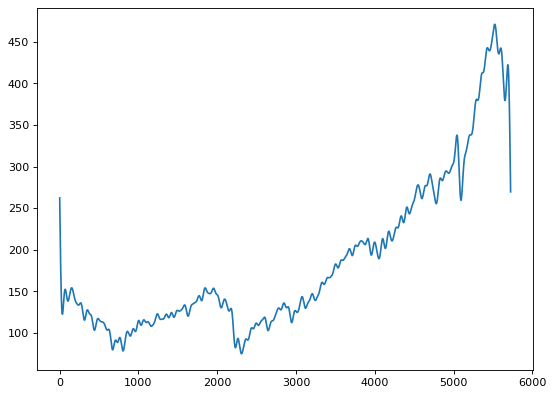

In [7]:
figure(figsize=(8, 6), dpi=80)
plt.plot(denoiser_test_1)

* Ploting the filtered results and the original data

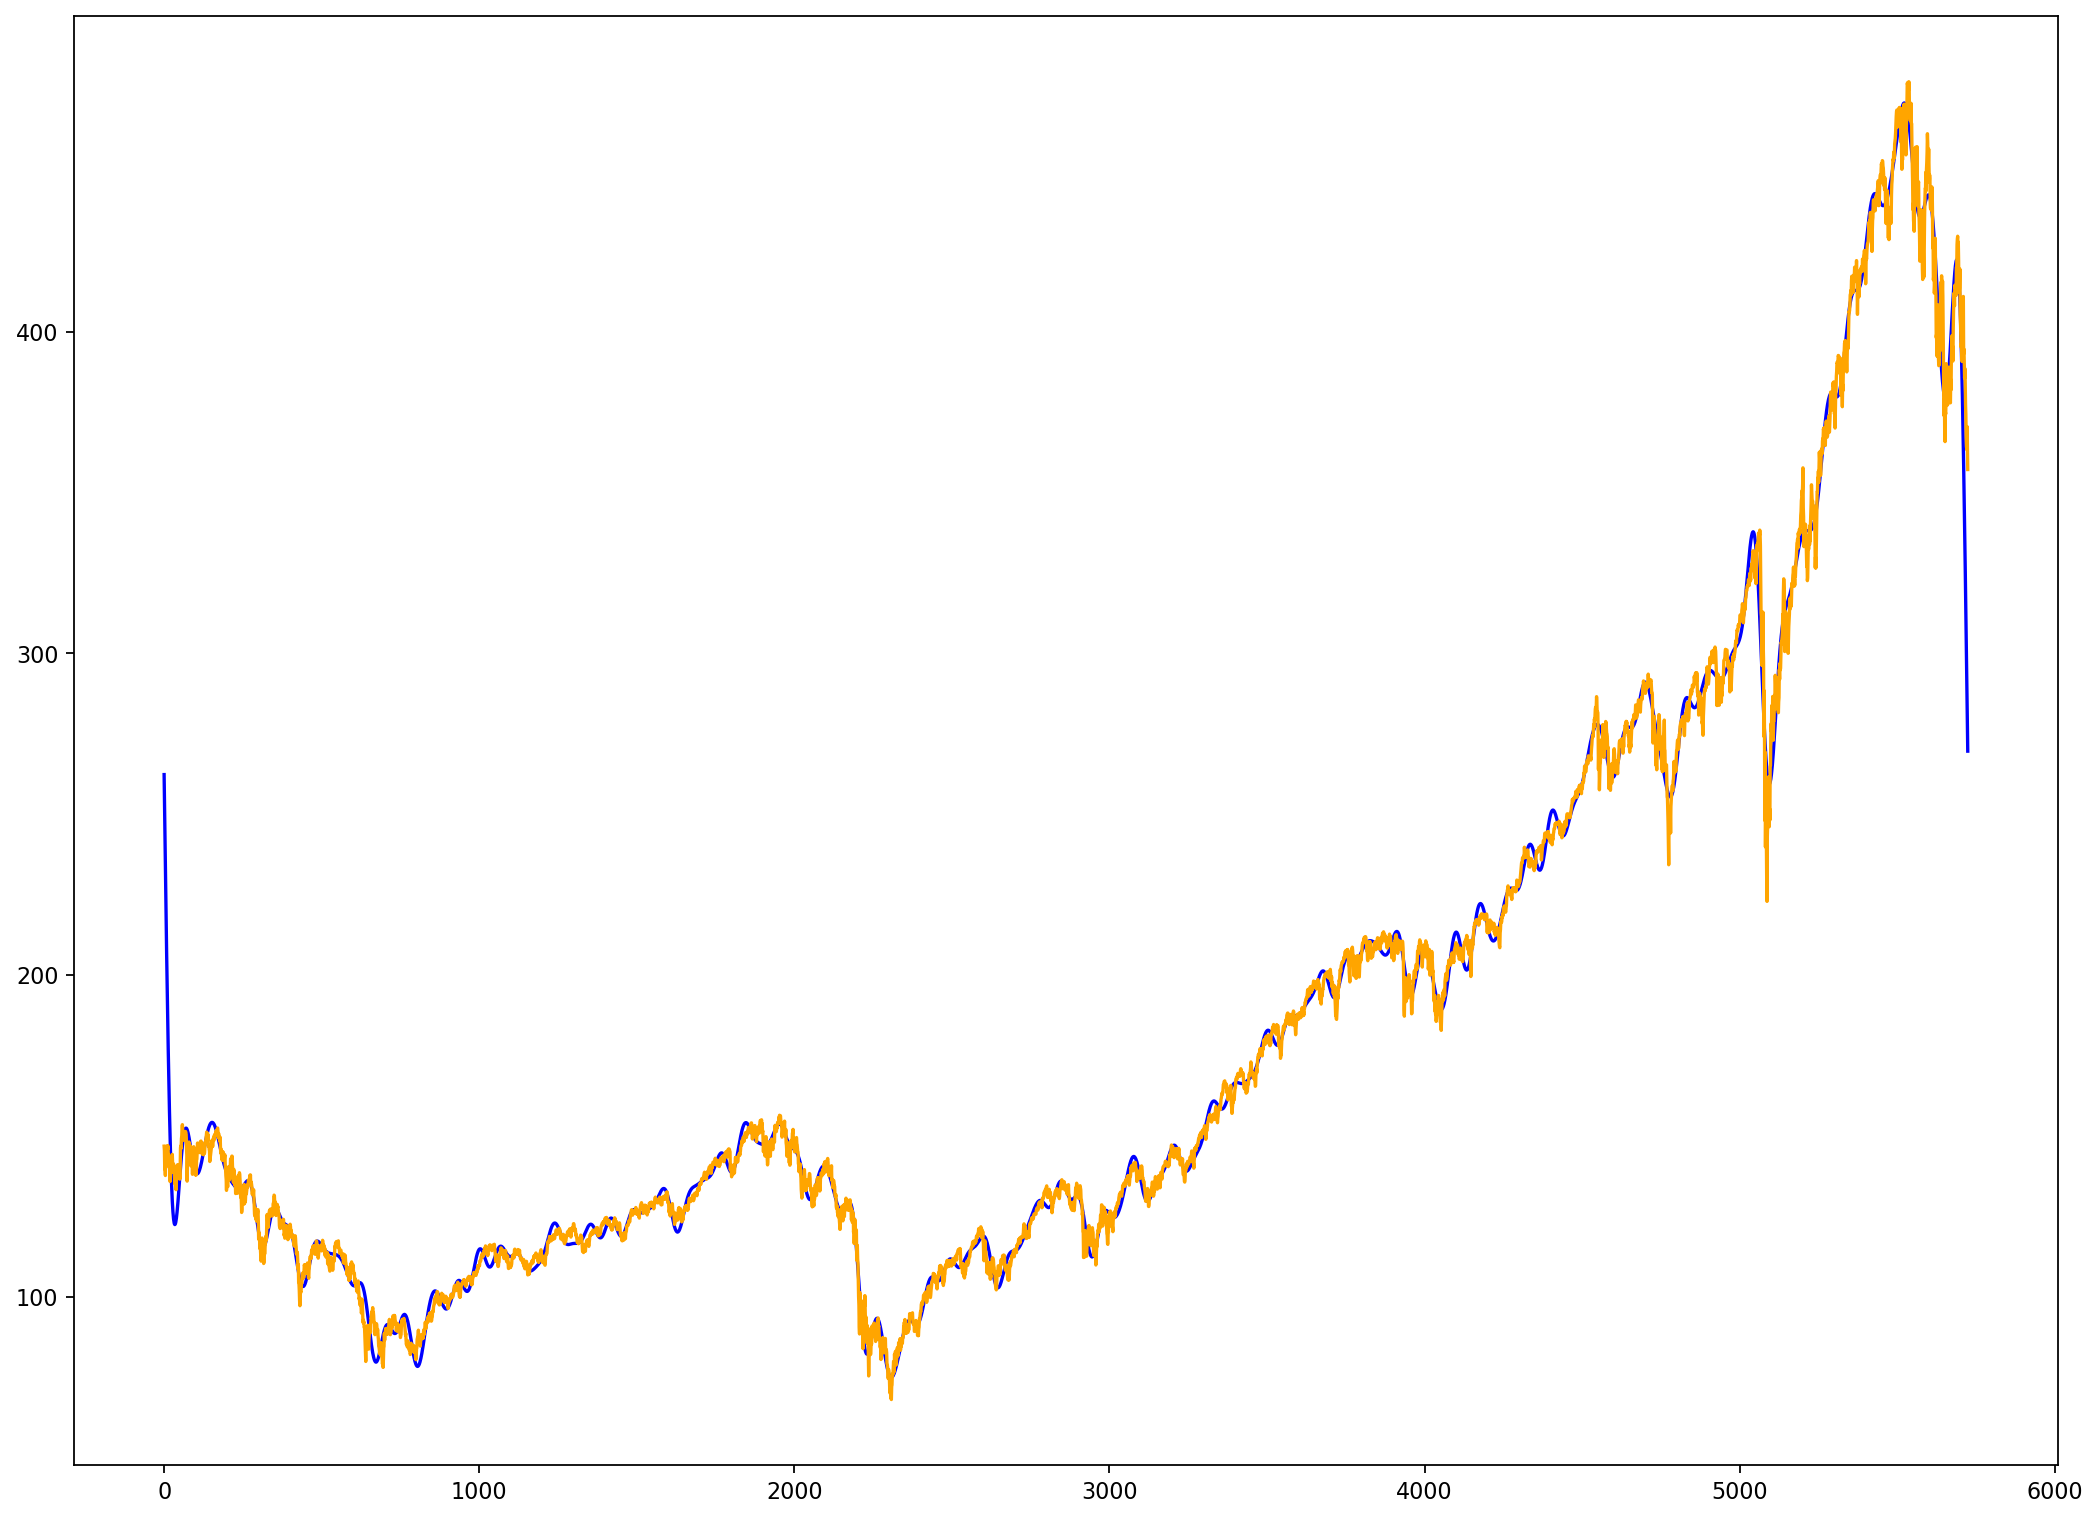

In [8]:
fig = plt.figure(figsize=(16, 12), dpi=160)
ax = fig.add_subplot(1, 1,1)
ax.plot(denoiser_test_1, color='blue')
ax.plot(SPY_array, color='orange')

* Secondly, we attempt to use KalmanFilter to attempt to reduce white noise

*Reference: https://github.com/quantopian/research_public/blob/master/notebooks/lectures/Kalman_Filters/notebook.ipynb*

In [9]:
from pykalman import KalmanFilter

* Construct a Kalman filter

*The mean is the model's guess for the mean of the distribution from which measurements are drawn, so our prediction of the next value is simply equal to our estimate of the mean. We assume that the observations have variance 1 around the rolling mean, for lack of a better estimate. Our initial guess for the mean is 0, but the filter quickly realizes that that is incorrect and adjusts.*

In [10]:
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

* Use the observed values of the price to get a rolling mean

In [11]:
state_means, _ = kf.filter(SPY_series.values)
state_means = pd.Series(state_means.flatten(), index=SPY_series.index)

* Plot original data and estimated mean

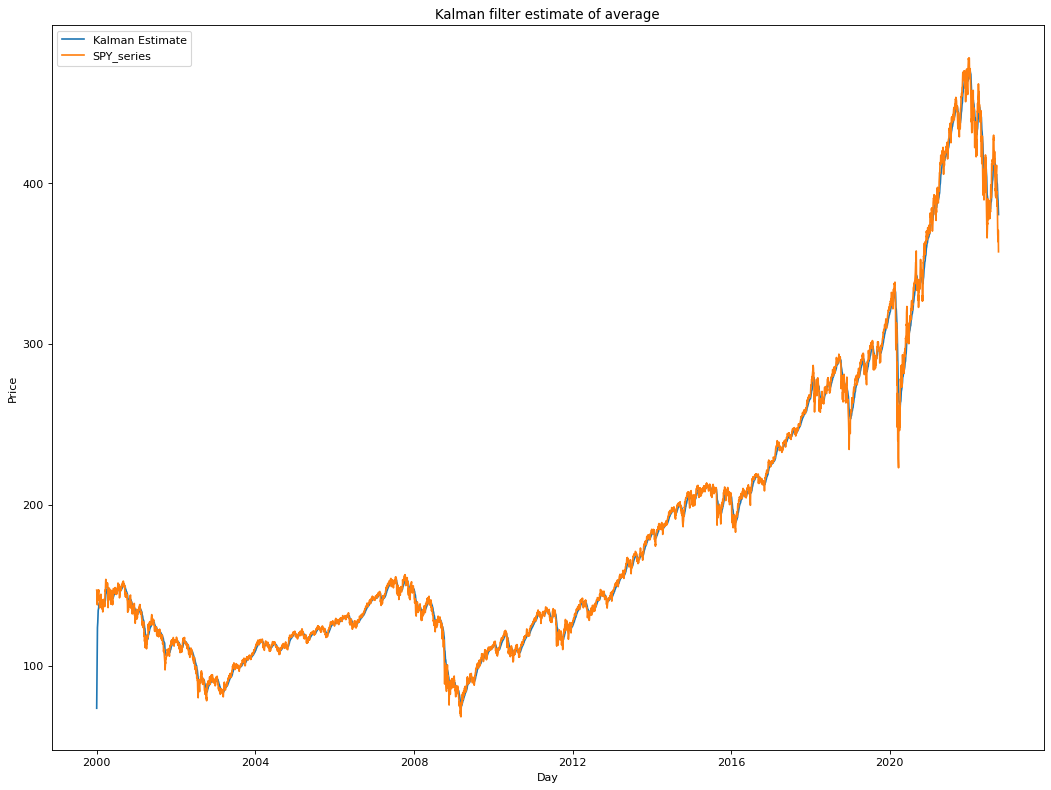

In [12]:
figure(figsize=(16, 12), dpi=80)
plt.plot(state_means)
plt.plot(SPY_series)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'SPY_series'])
plt.xlabel('Day')
plt.ylabel('Price');

*The advantage of the Kalman filter is that we don't need to select a window length, so we run less risk of overfitting. We do open ourselves up to overfitting with some of the initialization parameters for the filter, but those are slightly easier to objectively define. There's no free lunch and we can't eliminate overfitting, but a Kalman Filter is more rigorous than a moving average and generally better.*

# Backtrader test

* Creating datafreame for backtrader

Filtered Data of Fast fourier transform denoiser

In [13]:
SPY_FFT_filtered = pd.Series(denoiser_test_1)
SPY_FFT_filtered.index=SPY.index
SPY_df_FFT = SPY[['Open', 'High', 'Low', 'Adj Close','Volume']]
SPY_df_FFT['Close'] = SPY_FFT_filtered
SPY_data_FFT = bt.feeds.PandasData(dataname = SPY_df_FFT)

Filtered Data of KalmanFilter

In [14]:
SPY_df_Kalman = SPY[['Open', 'High', 'Low', 'Adj Close','Volume']]
SPY_df_Kalman['Close'] = state_means
SPY_data_Kalman = bt.feeds.PandasData(dataname = SPY_df_Kalman)

* Backtrader Strategy

In [15]:
from pickle import FALSE
import backtrader as bt

#from Data.AmeriTradeHistoryDataService import AmeriTradeHistoryDataService
#from Strategies import RSIStrategy as rsi
#from Data import BacktestResultDB as db
import backtrader.analyzers as btanalyzers
import backtrader as bt
import backtrader.indicators as btind
from SuperTrendIndicator import SuperTrend 
import datetime

class SuperTrendStrategy(bt.Strategy):
    
    def log(self, txt, dt= None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))


    def __init__(self):
        # To control operation entries
        self.dataclose = self.datas[0].close
        self.orderid = None
        self.st = SuperTrend(period = 10, multiplier = 3)
        self.hr = btind.HurstExponent(period=40)
        super().__init__()
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %(order.executed.price,order.executed.value,order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %(order.executed.price,order.executed.value,order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
   
    def next(self):
        #self.log('Close, %.2f' % self.dataclose[0])
    
        if self.orderid:
            return
    
        if self.position.size:
             if self.data < self.st and self.hr > 0.5:
                #self.sell_bracket(size=self.position.size, exectype=bt.Order.Close)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.sell(size=self.position.size, exectype=bt.Order.Close)

        elif self.st < self.data and self.hr > 0.5:
            size = int(self.broker.get_cash() / self.data)
            self.log('BUY CREATE, %.2f' % self.dataclose[0])
            self.buy(size=size, exectype=bt.Order.Close)

* Backtest based on FFT filtered data

Starting Portfolio Value: 10000.00
2000-07-21, BUY CREATE, 152.07
2000-07-24, BUY EXECUTED, Price: 152.40, Cost: 9906.29, Comm 9.91
2000-09-28, SELL CREATE, 142.05
2000-09-29, SELL EXECUTED, Price: 141.67, Cost: 9906.29, Comm 9.21
2001-05-01, BUY CREATE, 123.10
2001-05-02, BUY EXECUTED, Price: 123.59, Cost: 9269.09, Comm 9.27
2001-07-30, SELL CREATE, 121.58
2001-07-31, SELL EXECUTED, Price: 121.41, Cost: 9269.09, Comm 9.11
2001-11-09, BUY CREATE, 112.48
2001-11-12, BUY EXECUTED, Price: 112.95, Cost: 9035.71, Comm 9.04
2002-04-15, SELL CREATE, 110.03
2002-04-16, SELL EXECUTED, Price: 109.79, Cost: 9035.71, Comm 8.78
2003-04-25, BUY CREATE, 90.91
2003-04-28, Order Canceled/Margin/Rejected
2003-04-28, BUY CREATE, 91.58
2003-04-29, Order Canceled/Margin/Rejected
2003-04-29, BUY CREATE, 92.24
2003-04-30, Order Canceled/Margin/Rejected
2003-04-30, BUY CREATE, 92.89
2003-05-01, Order Canceled/Margin/Rejected
2003-05-01, BUY CREATE, 93.53
2003-05-02, Order Canceled/Margin/Rejected
2003-05-02, 

<IPython.core.display.Javascript object>


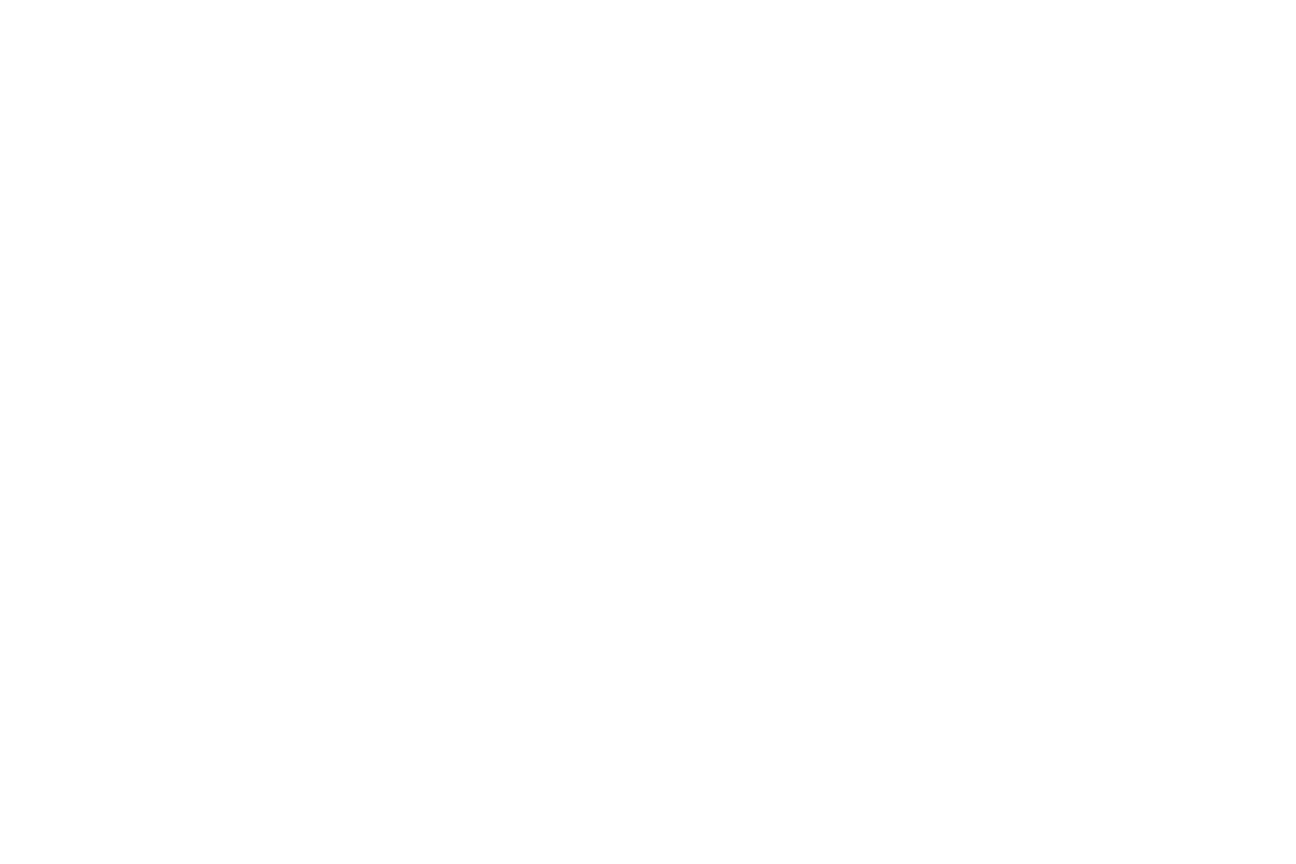

Final Portfolio Value: 56448.14


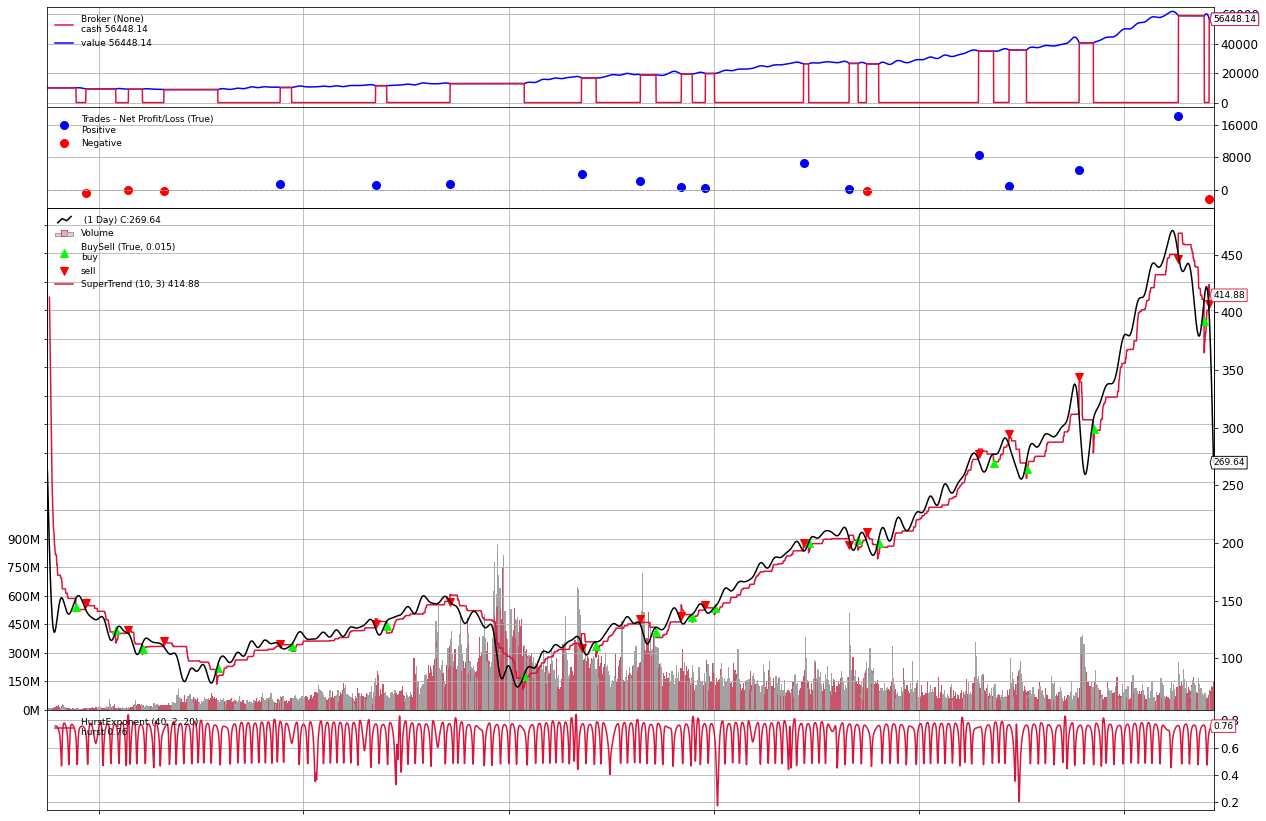

In [16]:
cerebro_FFT = bt.Cerebro()
     
cerebro_FFT.addstrategy(SuperTrendStrategy)
     
  
cerebro_FFT.broker.setcash(10000)
cerebro_FFT.broker.setcommission(commission=0.001)

#Feed strategy with data
backtestData = SPY_data_FFT
cerebro_FFT.adddata(backtestData)

#Running Backtest

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro_FFT.broker.getvalue())
cerebro_FFT.run()
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams.update({'font.size': 12}) 
cerebro_FFT.plot()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro_FFT.broker.getvalue())

* Backtest based on Kalamanfiltered data

Starting Portfolio Value: 10000.00
2000-08-29, BUY CREATE, 149.51
2000-08-30, BUY EXECUTED, Price: 149.59, Cost: 9872.83, Comm 9.87
2000-10-10, SELL CREATE, 143.75
2000-10-11, SELL EXECUTED, Price: 143.06, Cost: 9872.83, Comm 9.44
2003-05-08, BUY CREATE, 91.20
2003-05-09, BUY EXECUTED, Price: 91.44, Cost: 9509.86, Comm 9.51
2004-05-17, SELL CREATE, 111.27
2004-05-18, SELL EXECUTED, Price: 111.12, Cost: 9509.86, Comm 11.56
2004-11-15, BUY CREATE, 115.34
2004-11-16, BUY EXECUTED, Price: 115.58, Cost: 11558.27, Comm 11.56
2005-04-19, SELL CREATE, 117.25
2005-04-20, SELL EXECUTED, Price: 116.92, Cost: 11558.27, Comm 11.69
2005-07-14, BUY CREATE, 120.87
2005-07-15, BUY EXECUTED, Price: 121.06, Cost: 11621.34, Comm 11.62
2005-10-21, SELL CREATE, 119.52
2005-10-24, SELL EXECUTED, Price: 119.56, Cost: 11621.34, Comm 11.48
2005-12-02, BUY CREATE, 124.77
2005-12-05, BUY EXECUTED, Price: 124.95, Cost: 11494.99, Comm 11.49
2006-06-07, SELL CREATE, 127.90
2006-06-08, SELL EXECUTED, Price: 127.69, C

<IPython.core.display.Javascript object>


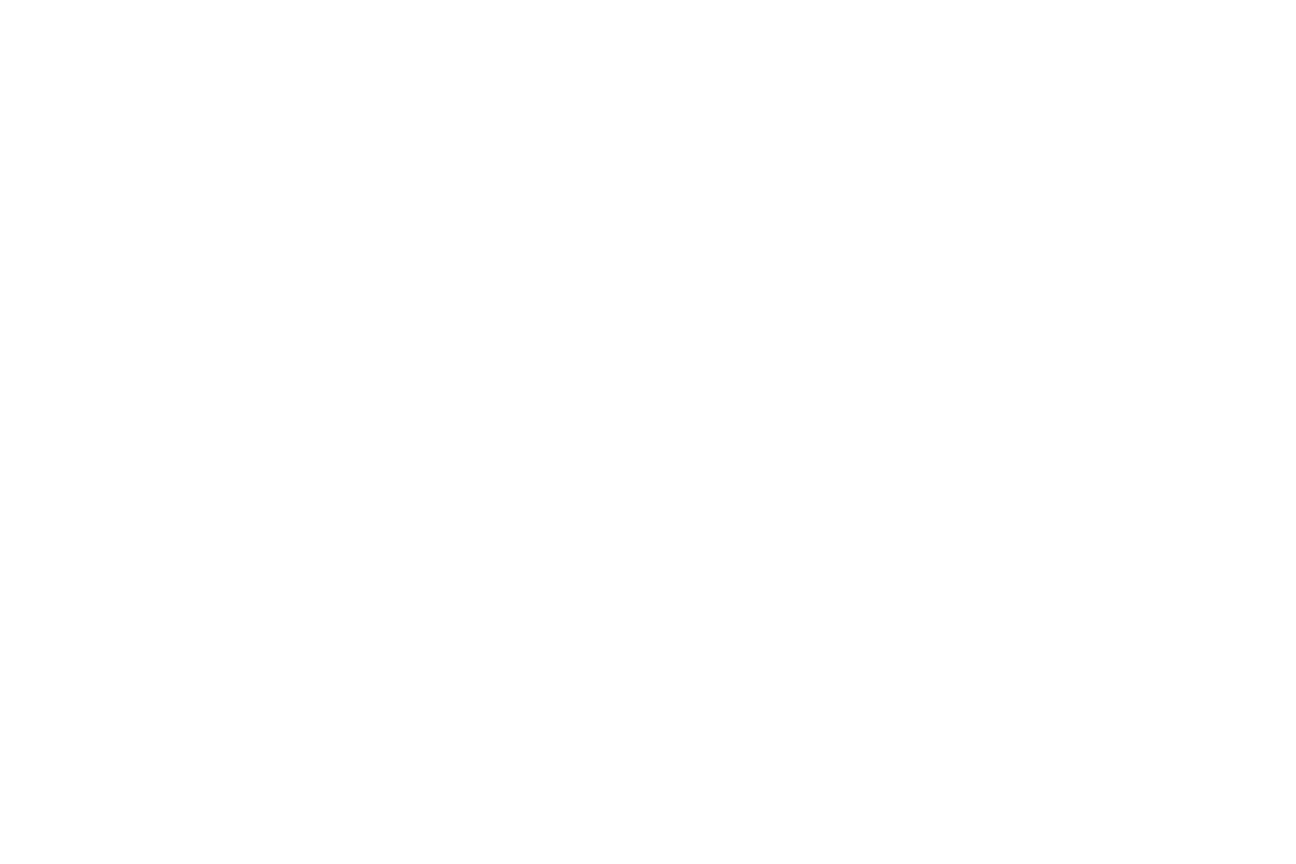

Final Portfolio Value: 44260.55


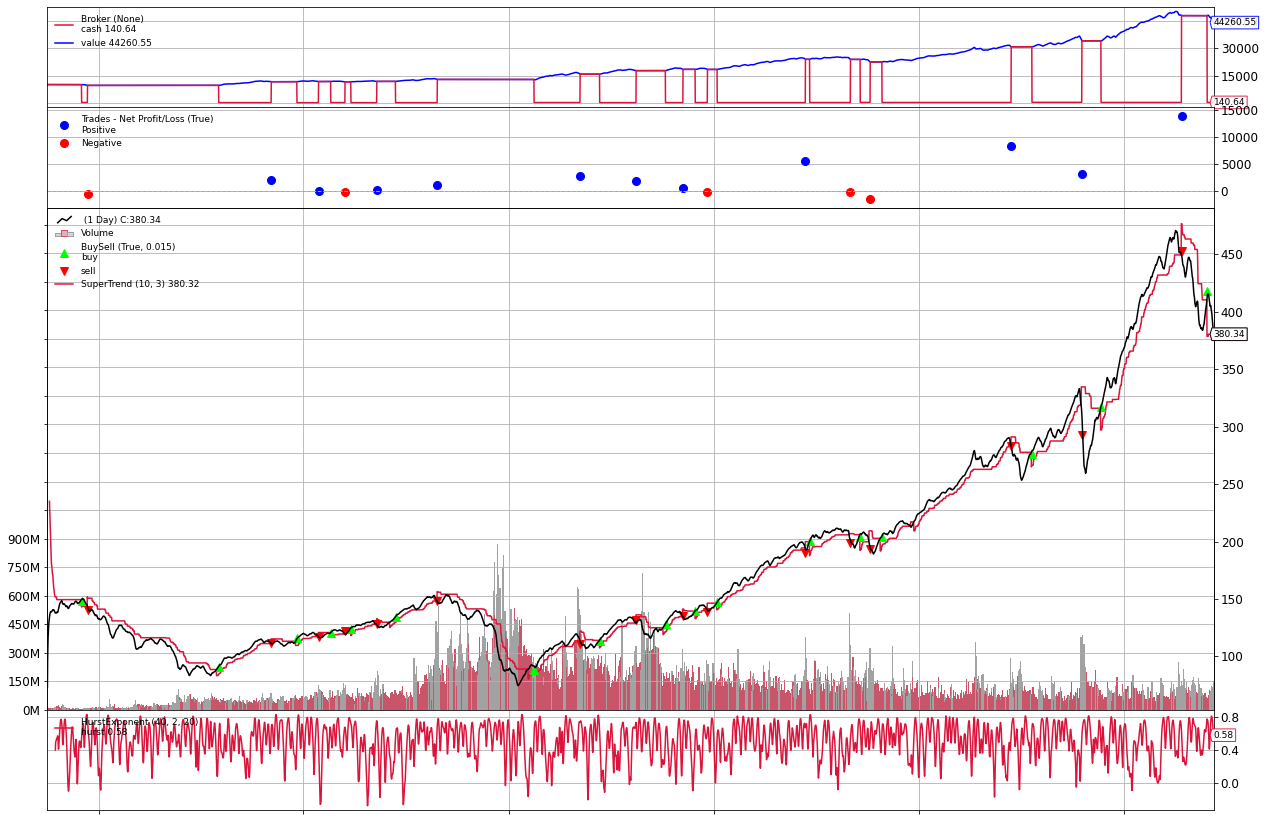

In [17]:
cerebro_Kalman = bt.Cerebro()
     
cerebro_Kalman.addstrategy(SuperTrendStrategy)
     
  
cerebro_Kalman.broker.setcash(10000)
cerebro_Kalman.broker.setcommission(commission=0.001)
cerebro_Kalman.adddata(SPY_data_Kalman)

#Running Backtest
# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro_Kalman.broker.getvalue())
cerebro_Kalman.run()
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams.update({'font.size': 12}) 
cerebro_Kalman.plot()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro_Kalman.broker.getvalue())